# Import Libraries

In [1]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
%matplotlib inline
import itertools
from PIL import Image

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import warnings
warnings.filterwarnings('ignore')

# Read Data

In [2]:
train_data='/kaggle/input/brain-tumor-mri-dataset/Training'
filepaths=[]
labels=[]

folds=os.listdir(train_data)

for fold in folds:
    foldpath=os.path.join(train_data,fold)
    filelist=os.listdir(foldpath)
    
    for fpath in filelist:
        fillpath=os.path.join(foldpath,fpath)
        
        labels.append(fold)
        filepaths.append(fillpath)
        
file_series=pd.Series(filepaths,name='filepaths')
label_series=pd.Series(labels,name='labels')
train_df=pd.concat([file_series,label_series],axis=1)

In [3]:
train_df

,filepaths,labels
0,/kaggle/input/brain-tumor-mri-dataset/Training...,pituitary
1,/kaggle/input/brain-tumor-mri-dataset/Training...,pituitary
2,/kaggle/input/brain-tumor-mri-dataset/Training...,pituitary
3,/kaggle/input/brain-tumor-mri-dataset/Training...,pituitary
4,/kaggle/input/brain-tumor-mri-dataset/Training...,pituitary
...,...,...
5707,/kaggle/input/brain-tumor-mri-dataset/Training...,glioma
5708,/kaggle/input/brain-tumor-mri-dataset/Training...,glioma
5709,/kaggle/input/brain-tumor-mri-dataset/Training...,glioma
5710,/kaggle/input/brain-tumor-mri-dataset/Training...,glioma


In [4]:
test_data='/kaggle/input/brain-tumor-mri-dataset/Testing'
filepaths=[]
labels=[]

folds=os.listdir(test_data)

for fold in folds:
    foldpath=os.path.join(test_data,fold)
    filelist=os.listdir(foldpath)
    
    for fpath in filelist:
        fillpath=os.path.join(foldpath,fpath)
        
        labels.append(fold)
        filepaths.append(fillpath)
        
file_series=pd.Series(filepaths,name='filepaths')
label_series=pd.Series(labels,name='labels')
ts_df=pd.concat([file_series,label_series],axis=1)

In [5]:
ts_df

,filepaths,labels
0,/kaggle/input/brain-tumor-mri-dataset/Testing/...,pituitary
1,/kaggle/input/brain-tumor-mri-dataset/Testing/...,pituitary
2,/kaggle/input/brain-tumor-mri-dataset/Testing/...,pituitary
3,/kaggle/input/brain-tumor-mri-dataset/Testing/...,pituitary
4,/kaggle/input/brain-tumor-mri-dataset/Testing/...,pituitary
...,...,...
1306,/kaggle/input/brain-tumor-mri-dataset/Testing/...,glioma
1307,/kaggle/input/brain-tumor-mri-dataset/Testing/...,glioma
1308,/kaggle/input/brain-tumor-mri-dataset/Testing/...,glioma
1309,/kaggle/input/brain-tumor-mri-dataset/Testing/...,glioma


# Preprocessing

In [6]:
val_df, test_df= train_test_split(ts_df,test_size=0.5,random_state= 43)

In [7]:
val_df

,filepaths,labels
185,/kaggle/input/brain-tumor-mri-dataset/Testing/...,pituitary
436,/kaggle/input/brain-tumor-mri-dataset/Testing/...,notumor
1149,/kaggle/input/brain-tumor-mri-dataset/Testing/...,glioma
999,/kaggle/input/brain-tumor-mri-dataset/Testing/...,meningioma
671,/kaggle/input/brain-tumor-mri-dataset/Testing/...,notumor
...,...,...
307,/kaggle/input/brain-tumor-mri-dataset/Testing/...,notumor
16,/kaggle/input/brain-tumor-mri-dataset/Testing/...,pituitary
58,/kaggle/input/brain-tumor-mri-dataset/Testing/...,pituitary
277,/kaggle/input/brain-tumor-mri-dataset/Testing/...,pituitary


###  image data generator

In [8]:
batch_size = 16
image_size = (224, 224)

train_genrator = ImageDataGenerator()
test_genrator = ImageDataGenerator()


train_genrator = train_genrator.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= image_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

valid_genrator = test_genrator.flow_from_dataframe( val_df, x_col= 'filepaths', y_col= 'labels', target_size= image_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

test_genrator = test_genrator.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= image_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= False, batch_size= batch_size)

Found 5712 validated image filenames belonging to 4 classes.
Found 655 validated image filenames belonging to 4 classes.
Found 656 validated image filenames belonging to 4 classes.


### Show sample from train data

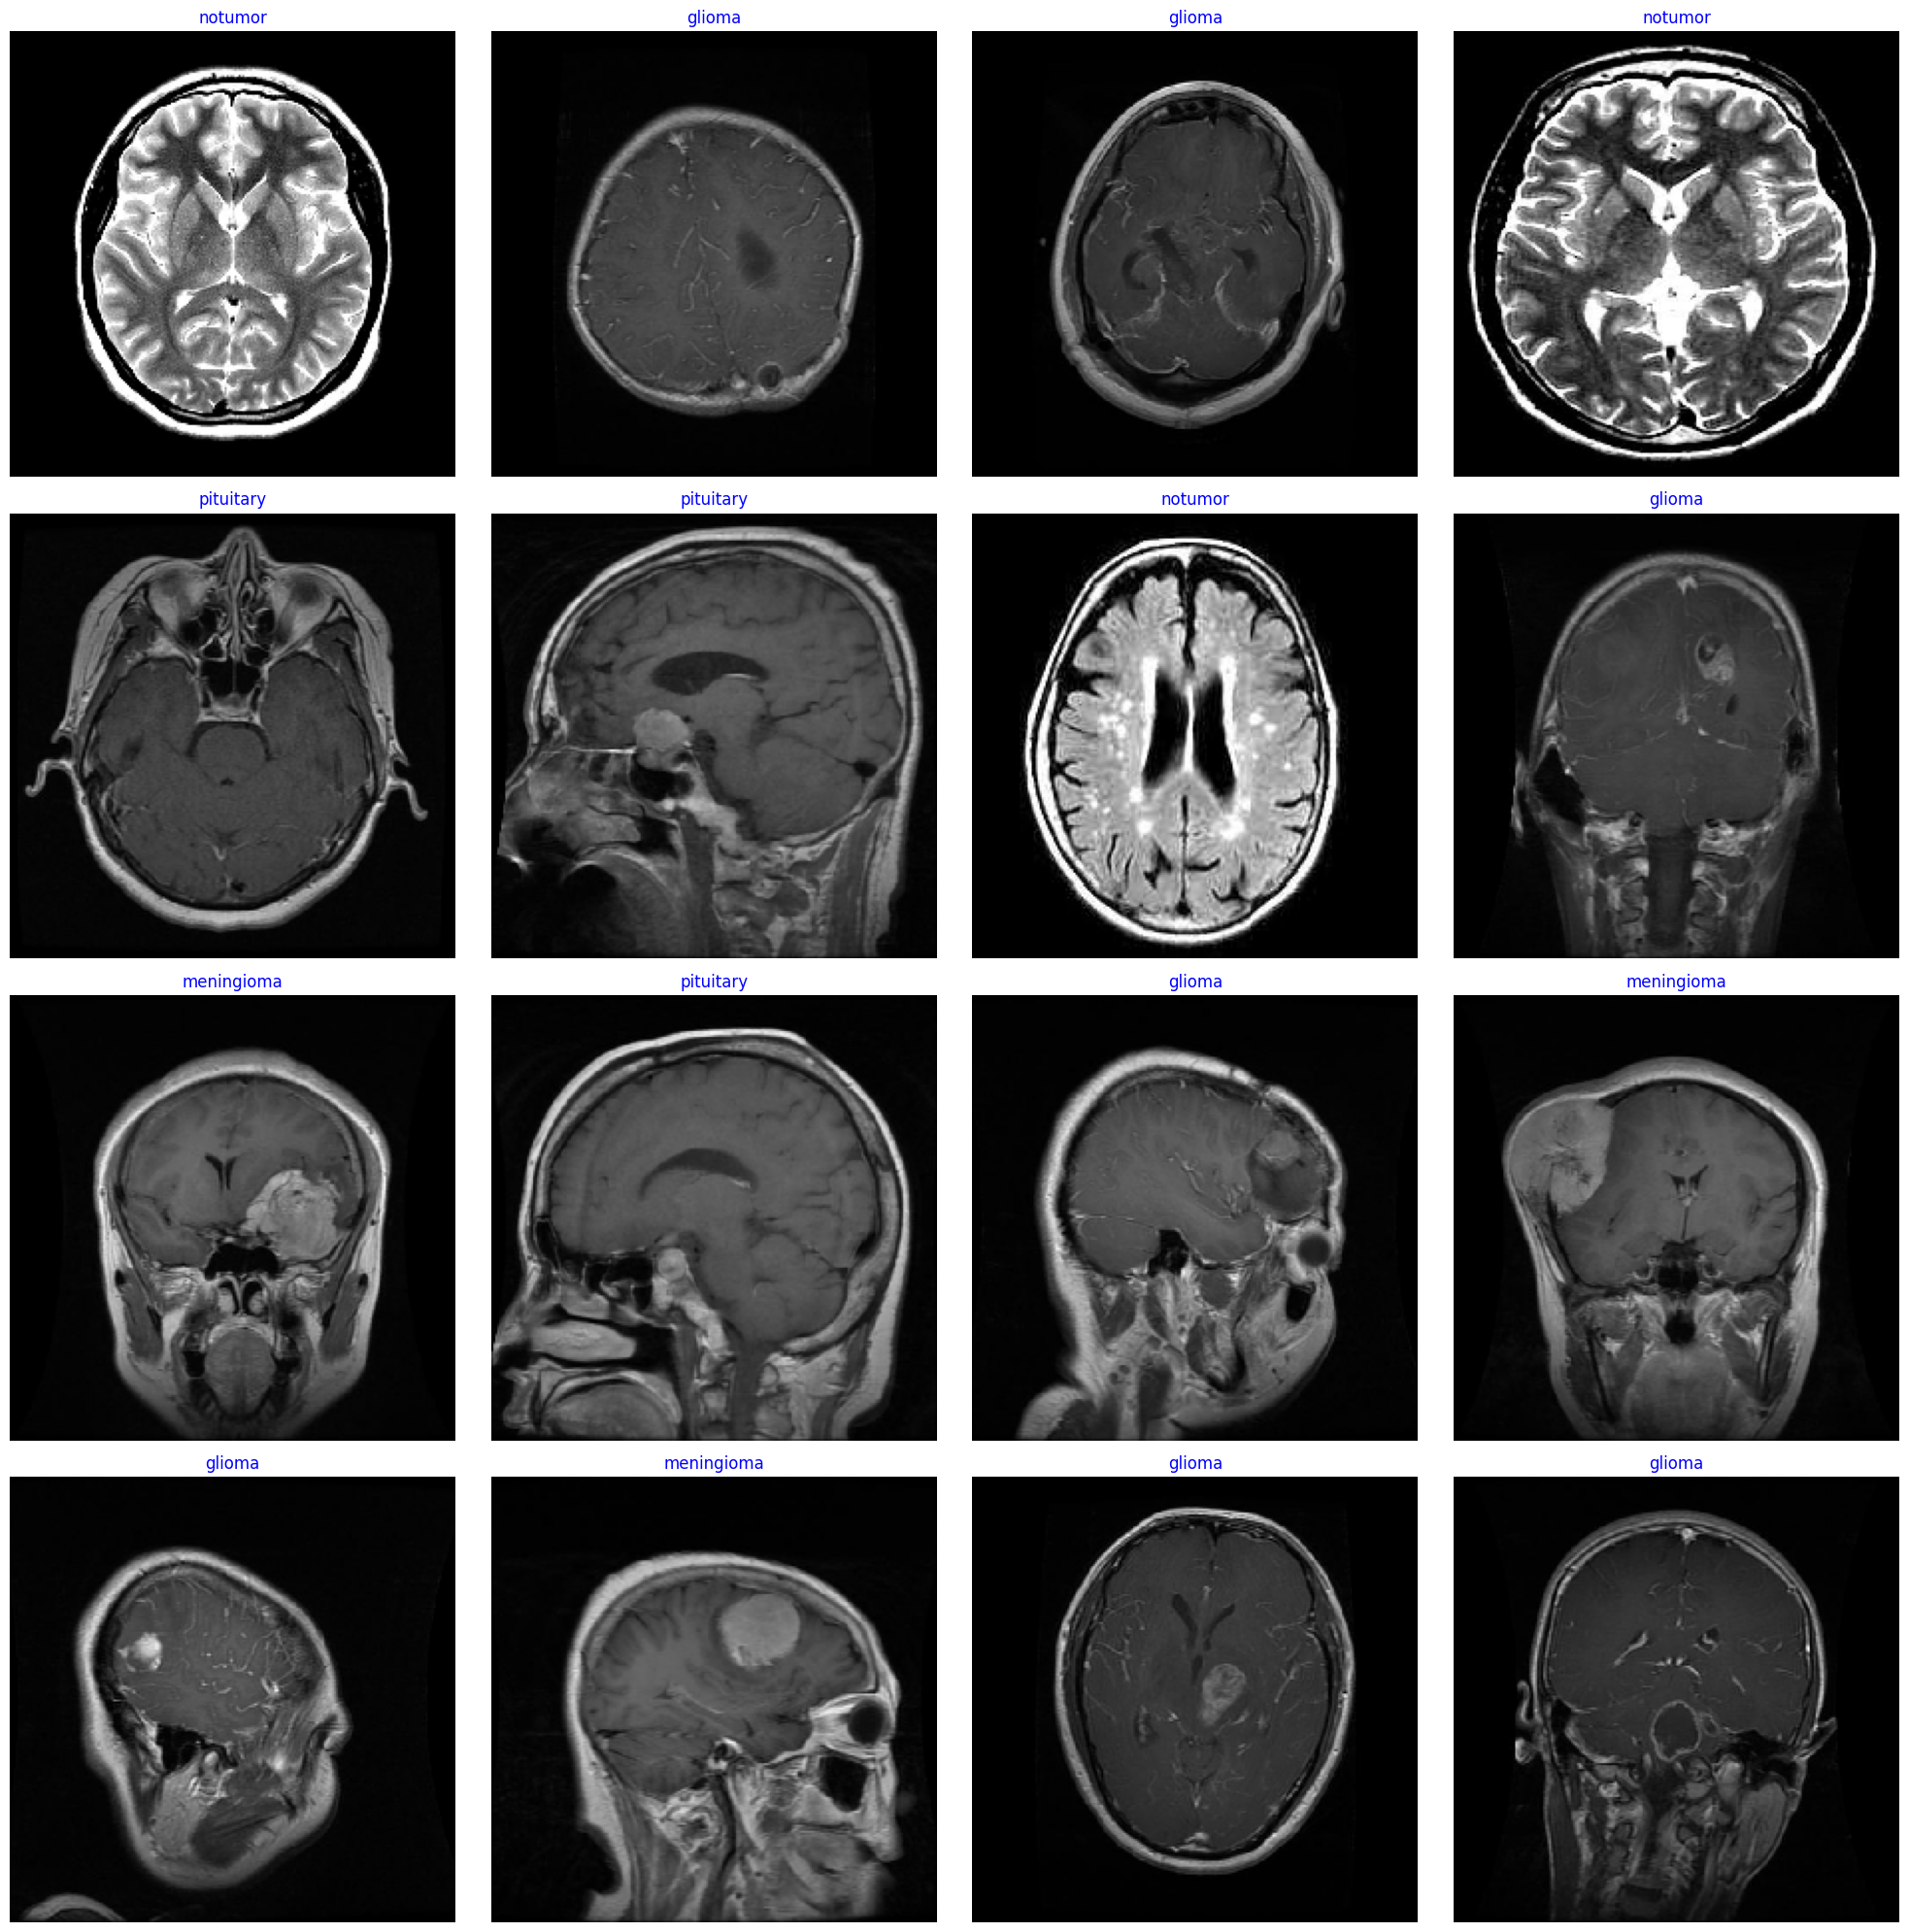

In [9]:
g_dict = train_genrator.class_indices      # defines dictionary {'class': index}
classes = list(g_dict.keys())       # defines list of dictionary's kays (classes), classes names : string
images, labels = next(train_genrator)      # get a batch size samples from the generator
# # difference between next iterator and for iterator


plt.figure(figsize= (20, 20))

for i in range(16):
    plt.subplot(4, 4, i + 1)
    image = images[i] / 255       # scales data to range (0 - 255)
    plt.imshow(image)
    index = np.argmax(labels[i])  # get image index
    class_name = classes[index]   # get class of image
    plt.title(class_name, color= 'blue', fontsize= 12)
    plt.axis('off')
plt.tight_layout()
plt.show()

# Build Model

In [10]:
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

class_count = len(list(train_genrator.class_indices.keys())) # to define number of classes in dense layer

model = Sequential([
    Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu", input_shape= img_shape),
    Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPooling2D((2, 2)),
    
    Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPooling2D((2, 2)),
    
    Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPooling2D((2, 2)),
    
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPooling2D((2, 2)),
    
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPooling2D((2, 2)),
    
    Flatten(),
    
    Dense(256,activation = "relu"),
    Dense(64,activation = "relu"),
    Dense(class_count, activation = "softmax")
])

model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,154,180 (80.70 MB)

 Trainable params: 21,154,180 (80.70 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
history = model.fit(train_genrator, epochs= 10, verbose= 1, validation_data= valid_genrator, shuffle= False)

Epoch 1/10


I0000 00:00:1726317392.899541      68 service.cc:145] XLA service 0x7b7d600034b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1726317392.899597      68 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


  1/357 ━━━━━━━━━━━━━━━━━━━━ 1:37:21 16s/step - accuracy: 0.5625 - loss: 1.3506

I0000 00:00:1726317405.223776      68 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


357/357 ━━━━━━━━━━━━━━━━━━━━ 63s 132ms/step - accuracy: 0.5240 - loss: 16.8266 - val_accuracy: 0.6962 - val_loss: 0.8122
Epoch 2/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 41s 114ms/step - accuracy: 0.8099 - loss: 0.4930 - val_accuracy: 0.7985 - val_loss: 0.4880
Epoch 3/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 41s 115ms/step - accuracy: 0.8935 - loss: 0.3084 - val_accuracy: 0.8458 - val_loss: 0.3852
Epoch 4/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 41s 114ms/step - accuracy: 0.9179 - loss: 0.2332 - val_accuracy: 0.8824 - val_loss: 0.3727
Epoch 5/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 41s 115ms/step - accuracy: 0.9384 - loss: 0.1805 - val_accuracy: 0.9115 - val_loss: 0.2734
Epoch 6/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 41s 115ms/step - accuracy: 0.9519 - loss: 0.1502 - val_accuracy: 0.9130 - val_loss: 0.2794
Epoch 7/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 41s 115ms/step - accuracy: 0.9628 - loss: 0.1105 - val_accuracy: 0.9313 - val_loss: 0.2111
Epoch 8/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 41s 115ms/step - accuracy: 0.9698 - loss: 0.0874 - va

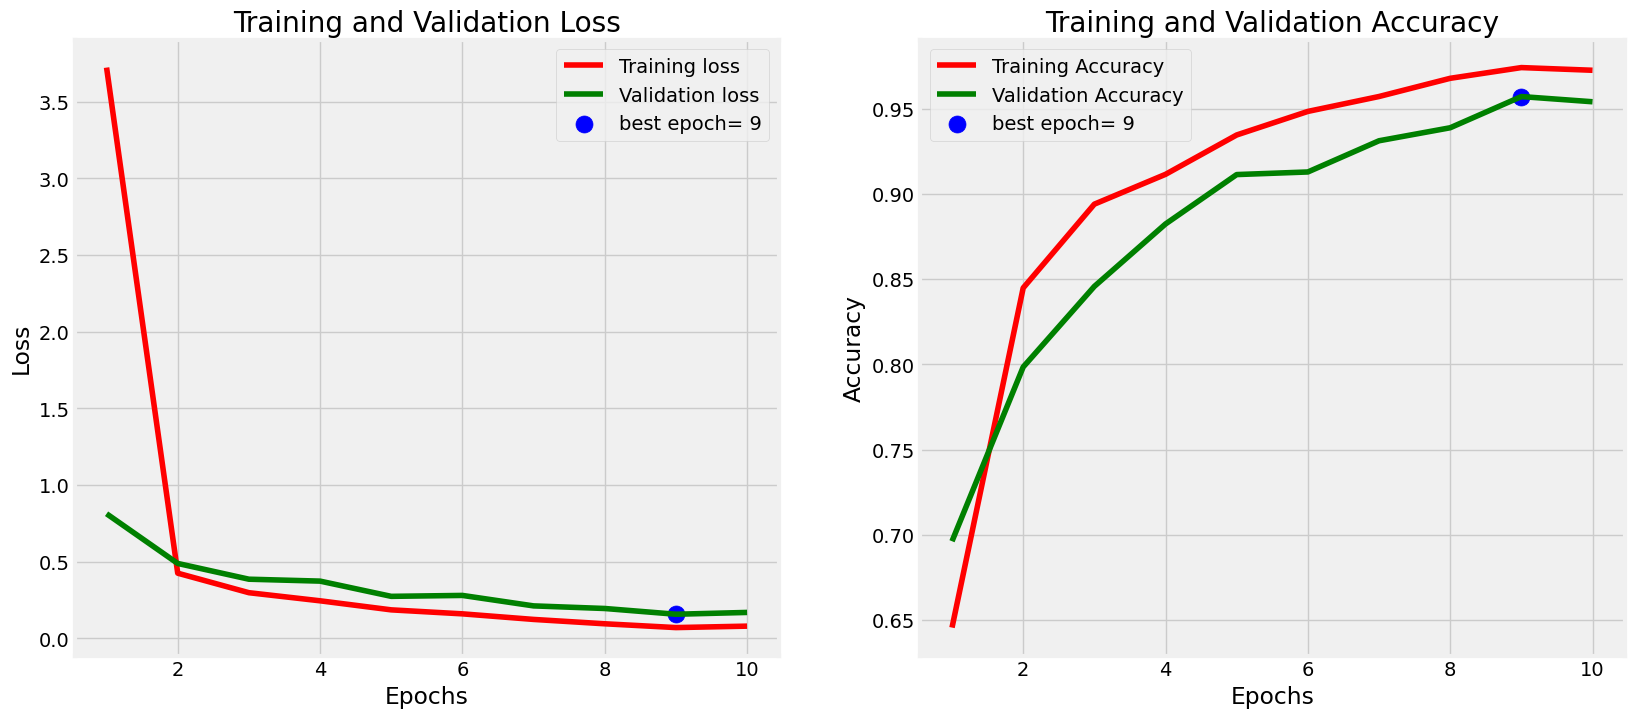

In [12]:
# Define needed variables
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]

Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

# Evaluate model

In [13]:
train_score = model.evaluate(train_genrator, verbose= 1)
valid_score = model.evaluate(valid_genrator, verbose= 1)
test_score = model.evaluate(test_genrator, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

357/357 ━━━━━━━━━━━━━━━━━━━━ 14s 39ms/step - accuracy: 0.9905 - loss: 0.0313
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.9567 - loss: 0.1462
41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 88ms/step - accuracy: 0.9597 - loss: 0.0936
Train Loss:  0.03286420553922653
Train Accuracy:  0.9900209903717041
--------------------
Validation Loss:  0.16846014559268951
Validation Accuracy:  0.9541984796524048
--------------------
Test Loss:  0.11232689023017883
Test Accuracy:  0.9557926654815674


# Get Predictions

In [14]:
preds = model.predict(test_genrator)  # [0.00001, 95.12312, 0.0021, 3.12313]
y_pred = np.argmax(preds, axis=1) 

41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step


# Confusion matrix

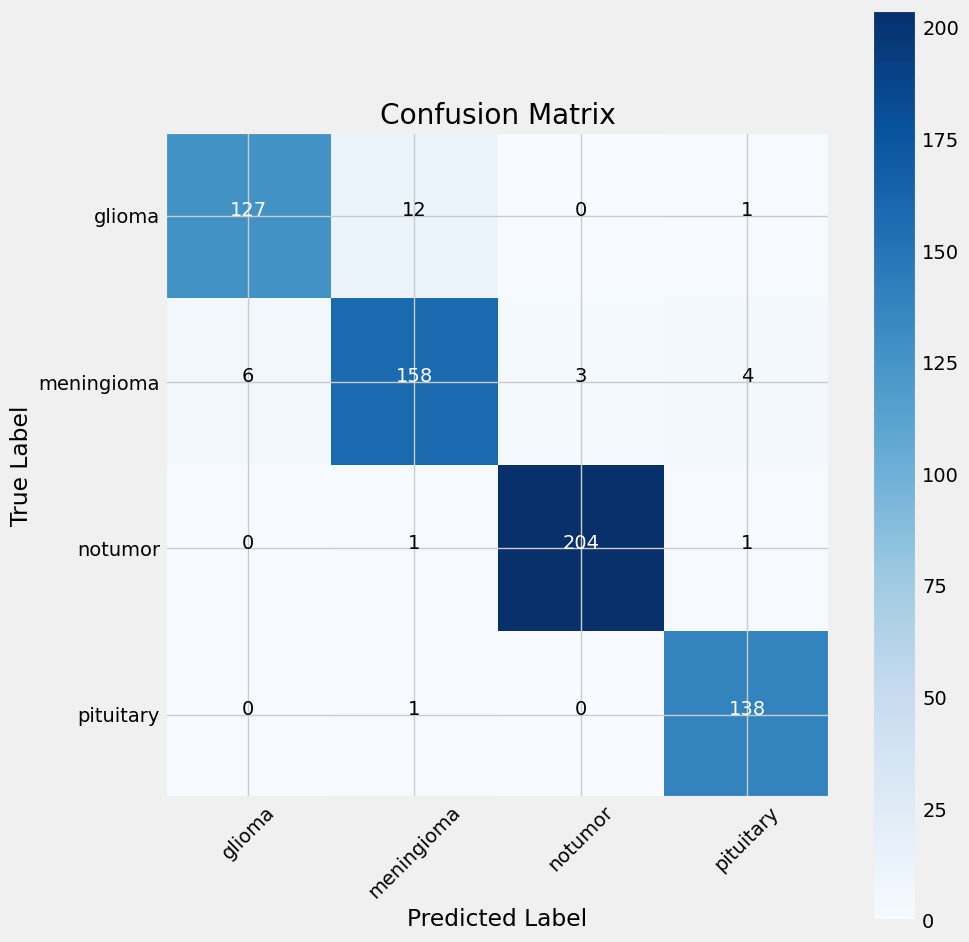

In [15]:
g_dict = test_genrator.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_genrator.classes, y_pred)
cm

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')
    
plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

# Classification Report

In [16]:
print(classification_report(test_genrator.classes, y_pred, target_names= classes))

              precision    recall  f1-score   support

      glioma       0.95      0.91      0.93       140
  meningioma       0.92      0.92      0.92       171
     notumor       0.99      0.99      0.99       206
   pituitary       0.96      0.99      0.98       139

    accuracy                           0.96       656
   macro avg       0.95      0.95      0.95       656
weighted avg       0.96      0.96      0.96       656

